#### Library import

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

#### GPU setting

In [30]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [31]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [32]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7963367828870967031
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11398169320330325690
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [33]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [34]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [35]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [36]:
As = data
Cd = data
Ni = data

In [37]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [38]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(1458, 16)
(1458, 16)
(1458, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [39]:
import smogn

In [40]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   1%|1         | 3/248 [00:00<00:33,  7.36it/s]

synth_matrix: 100%|##########| 242/242 [00:02<00:00, 111.86it/s]


In [41]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(2183, 16)
(2151, 16)
(2183, 16)


#### Eliminate outlier and train / test split

In [42]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [43]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [44]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [45]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [46]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1637, 15)
(1852, 15)
(2063, 15)


StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [47]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

MinMaxScaler

In [48]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [49]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1309, 15)
(1481, 15)
(1650, 15)


#### 10-Fold Crossvalidation

In [50]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [51]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [52]:
from sklearn.model_selection import cross_val_score

def objectiveGB(trial: Trial, X_train, y_train) -> float:
    gb_paramas = {
        "random_state": 42,
        "learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    gb = GradientBoostingRegressor(**gb_paramas)
    r2 = cross_val_score(gb, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [53]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="gb_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveGB(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 21:36:24,624] A new study created in memory with name: gb_parameter_opt
[I 2023-08-17 21:36:25,069] Trial 0 finished with value: 0.5192569790369308 and parameters: {'n_estimators': 140, 'max_depth': 29, 'min_samples_leaf': 10, 'min_samples_split': 2, 'subsample': 0.10509713479767041}. Best is trial 0 with value: 0.5192569790369308.
[I 2023-08-17 21:36:27,920] Trial 1 finished with value: 0.5759693233274259 and parameters: {'n_estimators': 179, 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 2, 'subsample': 0.3596029096107455}. Best is trial 1 with value: 0.5759693233274259.
[I 2023-08-17 21:36:28,825] Trial 2 finished with value: 0.5548712370514488 and parameters: {'n_estimators': 162, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 8, 'subsample': 0.3018781124152193}. Best is trial 1 with value: 0.5759693233274259.
[I 2023-08-17 21:36:29,467] Trial 3 finished with value: 0.5542253135971147 and parameters: {'n_estimators': 163, 'max_depth': 25, 'm

Best r2:  0.6107613838167556
Best trial: {'n_estimators': 176, 'max_depth': 12, 'min_samples_leaf': 9, 'min_samples_split': 5, 'subsample': 0.48563243815157614}


In [54]:
optuna.visualization.plot_optimization_history(study)

In [55]:
optuna.visualization.plot_param_importances(study)

In [56]:
optuna.visualization.plot_parallel_coordinate(study)

In [57]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 176, 'max_depth': 12, 'min_samples_leaf': 9, 'min_samples_split': 5, 'subsample': 0.48563243815157614}


In [58]:
study.best_trial.params["n_estimators"]

176

In [59]:
gb_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    "subsample": study.best_trial.params["subsample"]
}

gb = GradientBoostingRegressor(**gb_params)
gb.fit(As_X_train, As_y_train)

GradientBoostingRegressor(max_depth=12, min_samples_leaf=9, min_samples_split=5,
                          n_estimators=176, random_state=42,
                          subsample=0.48563243815157614)

In [60]:
# gb_params = {
#     "random_state": 42,
#     "learning_rate": 0.1,
#     "n_estimators": 100,
#     "max_depth": 2,
#     "min_samples_leaf": 8,
#     "min_samples_split": 2,
#     "subsample": 0.35775273871202684
# }

# gb = GradientBoostingRegressor(**gb_params)
# gb.fit(As_X_train, As_y_train)

In [61]:
y_train_pred = gb.predict(As_X_train)
y_test_pred = gb.predict(As_X_test)

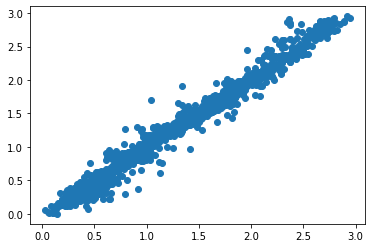

In [62]:
plt.scatter(y_train_pred, np.array(As_y_train))

In [63]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.11415510397645624
Test RMSE:  0.40807167325000665


In [64]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.9770365635394304
Test R2:  0.7219653014933873


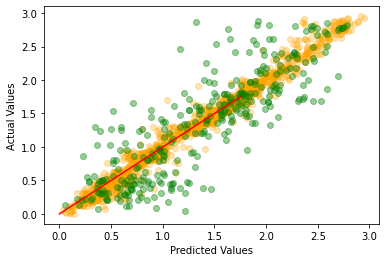

In [65]:
import matplotlib.pyplot as plt

plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add trendline
# z = np.polyfit(y_train_pred, As_y_train, 1)
# p = np.poly1d(z)
# plt.plot(y_train_pred, p(y_train_pred), color='red', linestyle='-')

# Add y=x line
plt.plot([0, 1.75], [0, 1.75], color='red', linestyle='-')

plt.show()

In [66]:
# import shap

# #background = shap.sample(As_X_train, 100)  # Adjust the number of samples as needed

# explainer = shap.KernelExplainer(gb.predict, As_X_train)
# shap_values = explainer.shap_values(As_X_train)

# shap.summary_plot(shap_values, As_X_train)

# shap.force_plot(explainer.expected_value, shap_values[0], As_X_train[0])

# print(shap_values)

Cd

Optimization

In [67]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="gb_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveGB(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 21:39:13,694] A new study created in memory with name: gb_parameter_opt
[I 2023-08-17 21:39:14,234] Trial 0 finished with value: 0.6540542574790396 and parameters: {'n_estimators': 104, 'max_depth': 26, 'min_samples_leaf': 3, 'min_samples_split': 5, 'subsample': 0.15642091597960017}. Best is trial 0 with value: 0.6540542574790396.
[I 2023-08-17 21:39:15,067] Trial 1 finished with value: 0.6691295090039818 and parameters: {'n_estimators': 141, 'max_depth': 18, 'min_samples_leaf': 4, 'min_samples_split': 5, 'subsample': 0.1975038841753614}. Best is trial 1 with value: 0.6691295090039818.
[I 2023-08-17 21:39:16,801] Trial 2 finished with value: 0.6900378285756766 and parameters: {'n_estimators': 196, 'max_depth': 28, 'min_samples_leaf': 5, 'min_samples_split': 9, 'subsample': 0.2989016204321012}. Best is trial 2 with value: 0.6900378285756766.
[I 2023-08-17 21:39:17,619] Trial 3 finished with value: 0.6804895444636205 and parameters: {'n_estimators': 169, 'max_depth': 4, 'mi

Best r2:  0.7062195628594823
Best trial: {'n_estimators': 144, 'max_depth': 16, 'min_samples_leaf': 8, 'min_samples_split': 8, 'subsample': 0.42660183516459393}


In [68]:
optuna.visualization.plot_parallel_coordinate(study)

In [69]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 144, 'max_depth': 16, 'min_samples_leaf': 8, 'min_samples_split': 8, 'subsample': 0.42660183516459393}


144

In [70]:
gb_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    "subsample": study.best_trial.params["subsample"]
}

gb = GradientBoostingRegressor(**gb_params)
gb.fit(Cd_X_train, Cd_y_train)

GradientBoostingRegressor(max_depth=16, min_samples_leaf=8, min_samples_split=8,
                          n_estimators=144, random_state=42,
                          subsample=0.42660183516459393)

In [71]:
# gb_params = {
#     "random_state": 42,
#     "learning_rate": 0.1,
#     "n_estimators": 138,
#     "max_depth": 2,
#     "min_samples_leaf": 3,
#     "min_samples_split": 6,
#     "subsample": 0.4574655226902498
# }

# gb = GradientBoostingRegressor(**gb_params)
# gb.fit(Cd_X_train, Cd_y_train)

In [72]:
y_train_pred = gb.predict(Cd_X_train)
y_test_pred = gb.predict(Cd_X_test)

In [73]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.03262669712854114
Test RMSE:  0.115299603270424


In [74]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.9749187679553306
Test R2:  0.686410803169911


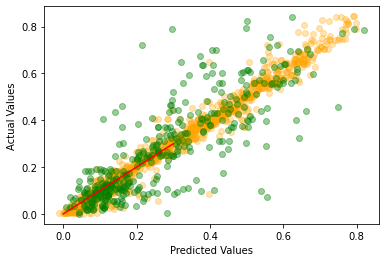

In [75]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.30], [0, 0.30], color='red', linestyle='-')

plt.show()

In [76]:
# explainer = shap.KernelExplainer(gb.predict, Cd_X_train)
# shap_values = explainer.shap_values(Cd_X_train)

# shap.summary_plot(shap_values, Cd_X_train)

# shap.force_plot(explainer.expected_value, shap_values[0], Cd_X_train[0])

# print(shap_values)

Ni

In [77]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="gb_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveGB(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 21:41:38,420] A new study created in memory with name: gb_parameter_opt
[I 2023-08-17 21:41:39,951] Trial 0 finished with value: 0.7497038011893244 and parameters: {'n_estimators': 152, 'max_depth': 17, 'min_samples_leaf': 10, 'min_samples_split': 3, 'subsample': 0.34418243436798257}. Best is trial 0 with value: 0.7497038011893244.
[I 2023-08-17 21:41:41,316] Trial 1 finished with value: 0.7435064022378135 and parameters: {'n_estimators': 119, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'subsample': 0.490327589355012}. Best is trial 0 with value: 0.7497038011893244.
[I 2023-08-17 21:41:41,939] Trial 2 finished with value: 0.7023977566014196 and parameters: {'n_estimators': 153, 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2, 'subsample': 0.21786836688828584}. Best is trial 0 with value: 0.7497038011893244.
[I 2023-08-17 21:41:44,618] Trial 3 finished with value: 0.726963042484958 and parameters: {'n_estimators': 137, 'max_depth': 21, 'mi

Best r2:  0.7604737746218186
Best trial: {'n_estimators': 185, 'max_depth': 16, 'min_samples_leaf': 9, 'min_samples_split': 2, 'subsample': 0.3312431251547609}


In [78]:
optuna.visualization.plot_parallel_coordinate(study)

In [79]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 185, 'max_depth': 16, 'min_samples_leaf': 9, 'min_samples_split': 2, 'subsample': 0.3312431251547609}


185

In [80]:
gb_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    "subsample": study.best_trial.params["subsample"]
}

gb = GradientBoostingRegressor(**gb_params)
gb.fit(Ni_X_train, Ni_y_train)

GradientBoostingRegressor(max_depth=16, min_samples_leaf=9, n_estimators=185,
                          random_state=42, subsample=0.3312431251547609)

In [81]:
# gb_params = {
#     "random_state": 42,
#     "learning_rate": 0.1,
#     "n_estimators": 181,
#     "max_depth": 28,
#     "min_samples_leaf": 7,
#     "min_samples_split": 7,
#     "subsample": 0.4946447123833718
# }

# gb = GradientBoostingRegressor(**gb_params)
# gb.fit(Ni_X_train, Ni_y_train)

In [82]:
y_train_pred = gb.predict(Ni_X_train)
y_test_pred = gb.predict(Ni_X_test)

In [83]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.19029950608262708
Test RMSE:  0.6022954209290023


In [84]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9757641767060837
Test R2:  0.7391953912779796


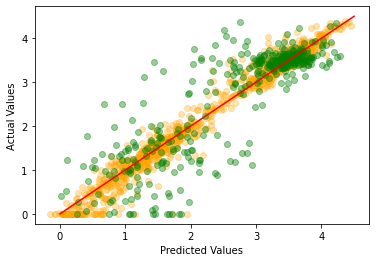

In [85]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto")
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add trendline
# z = np.polyfit(y_train_pred, As_y_train, 1)
# p = np.poly1d(z)
# plt.plot(y_train_pred, p(y_train_pred), color='red', linestyle='-')

# Add y=x line
plt.plot([0, 4.5], [0, 4.5], color='red', linestyle='-')

plt.show()